<a href="https://colab.research.google.com/github/eunicean/Proyecto-DeepLearning/blob/main/CNN/HIRAGANA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("farukece/handwritten-japanese-hiragana-characters")

print("Path to dataset files:", dataset_path)

100%|██████████| 31.7M/31.7M [00:02<00:00, 12.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farukece/handwritten-japanese-hiragana-characters/versions/1


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from collections import Counter


In [3]:
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')

    # Solo mostrar los primeros niveles para no saturar
    if level < 2:
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Mostrar solo los primeros 5 archivos
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... y {len(files) - 5} archivos más')

    if level >= 3:
        break

1/
  hiragana/
    wo/
    ka/
    mi/
    so/
    wa/
    mu/
    ni/
    aa/
    no/
    chi/
    nn/
    ha/
    nu/
    ke/
    re/
    shi/
    na/
    fu/
    ne/
    ho/
    ku/
    uu/
    ro/
    hi/
    su/
    me/
    to/
    he/
    ma/
    se/
    sa/
    ya/
    tsu/
    yo/
    ee/
    ri/
    ru/
    ra/
    yu/
    oo/
    ii/
    mo/
    ko/
    ta/
    te/
    ki/


In [4]:
# Analizar cada carpeta de hiragana
hiragana_path = os.path.join(dataset_path, "hiragana")

# Diccionario para almacenar la información
hiragana_data = {}

print("Conteo de imágenes por carácter Hiragana:")

for character_folder in sorted(os.listdir(hiragana_path)):
    folder_path = os.path.join(hiragana_path, character_folder)

    if os.path.isdir(folder_path):
        # Contar archivos de imagen
        image_files = [f for f in os.listdir(folder_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        hiragana_data[character_folder] = {
            'num_imagenes': len(image_files),
            'ruta': folder_path,
            'archivos': image_files
        }

        print(f"{character_folder:8s} tiene {len(image_files):3d} imágenes")

# Crear DataFrame para análisis
df_hiragana = pd.DataFrame.from_dict(hiragana_data, orient='index')
df_hiragana = df_hiragana.reset_index().rename(columns={'index': 'caracter'})

print("\n")
print(f"RESUMEN:")
print(f"Total de caracteres: {len(df_hiragana)}")
print(f"Total de imágenes: {df_hiragana['num_imagenes'].sum()}")
print(f"\nEstadísticas:")
print(f"  - Mínimo: {df_hiragana['num_imagenes'].min()} imágenes")
print(f"  - Máximo: {df_hiragana['num_imagenes'].max()} imágenes")
print(f"  - Promedio: {df_hiragana['num_imagenes'].mean():.2f} imágenes")
print(f"  - Mediana: {df_hiragana['num_imagenes'].median():.0f} imágenes")

# Verificar si todas las clases tienen 100 imágenes
clases_con_100 = df_hiragana[df_hiragana['num_imagenes'] == 100]
print(f"\nClases con exactamente 100 imágenes: {len(clases_con_100)}/{len(df_hiragana)}")

if len(df_hiragana) != len(clases_con_100):
    print("\nClases con cantidad diferente a 100:")
    clases_diferentes = df_hiragana[df_hiragana['num_imagenes'] != 100]
    for _, row in clases_diferentes.iterrows():
        print(f"  - {row['caracter']}: {row['num_imagenes']} imágenes")

Conteo de imágenes por carácter Hiragana:
aa       tiene 100 imágenes
chi      tiene 100 imágenes
ee       tiene 100 imágenes
fu       tiene 100 imágenes
ha       tiene 100 imágenes
he       tiene 100 imágenes
hi       tiene 100 imágenes
ho       tiene 100 imágenes
ii       tiene 100 imágenes
ka       tiene 100 imágenes
ke       tiene 100 imágenes
ki       tiene 100 imágenes
ko       tiene 100 imágenes
ku       tiene 100 imágenes
ma       tiene 100 imágenes
me       tiene 100 imágenes
mi       tiene 100 imágenes
mo       tiene 100 imágenes
mu       tiene 100 imágenes
na       tiene 100 imágenes
ne       tiene 100 imágenes
ni       tiene 100 imágenes
nn       tiene 100 imágenes
no       tiene 100 imágenes
nu       tiene 100 imágenes
oo       tiene 100 imágenes
ra       tiene 100 imágenes
re       tiene 100 imágenes
ri       tiene 100 imágenes
ro       tiene 100 imágenes
ru       tiene 100 imágenes
sa       tiene 100 imágenes
se       tiene 100 imágenes
shi      tiene 100 imágenes
so    

# División de datos en entrenamiento y prueba

In [5]:
from sklearn.model_selection import train_test_split
import shutil

# Configuración de la división
TRAIN_RATIO = 0.70  # 70% entrenamiento
VAL_RATIO = 0.15    # 15% validación
TEST_RATIO = 0.15   # 15% test

print(" Configuración de división del dataset:")
print("\n")
print(f"Train: {TRAIN_RATIO*100:.0f}% ({int(100*TRAIN_RATIO)} imágenes por clase)")
print(f"Validation: {VAL_RATIO*100:.0f}% ({int(100*VAL_RATIO)} imágenes por clase)")
print(f"Test: {TEST_RATIO*100:.0f}% ({int(100*TEST_RATIO)} imágenes por clase)")
print(f"\nTotal por clase: 100 imágenes")
print("\n")

# Crear estructura de directorios
base_output_path = "/content/hiragana_dataset"
splits = ['train', 'val', 'test']

# Crear carpetas
for split in splits:
    split_path = os.path.join(base_output_path, split)
    os.makedirs(split_path, exist_ok=True)
    print(f" Creado: {split_path}")

print("\nProcesando división del dataset...")

# Realizar la división estratificada para cada clase
np.random.seed(42)  # Para reproducibilidad

stats = {
    'train': 0,
    'val': 0,
    'test': 0
}

for character in sorted(df_hiragana['caracter']):
    # Obtener la ruta de la carpeta del carácter
    source_folder = os.path.join(hiragana_path, character)

    # Obtener lista de imágenes
    images = [f for f in os.listdir(source_folder)
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Mezclar aleatoriamente
    np.random.shuffle(images)

    # Calcular índices de división
    n_images = len(images)
    train_end = int(n_images * TRAIN_RATIO)
    val_end = train_end + int(n_images * VAL_RATIO)

    # Dividir las imágenes
    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    # Crear carpetas para cada split
    for split in splits:
        split_char_path = os.path.join(base_output_path, split, character)
        os.makedirs(split_char_path, exist_ok=True)

    # Copiar imágenes a sus respectivas carpetas
    # TRAIN
    for img in train_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'train', character, img)
        shutil.copy2(src, dst)
        stats['train'] += 1

    # VALIDATION
    for img in val_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'val', character, img)
        shutil.copy2(src, dst)
        stats['val'] += 1

    # TEST
    for img in test_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'test', character, img)
        shutil.copy2(src, dst)
        stats['test'] += 1

print("\nDivisión completada!")
print("\nResumen de la división:")
print("\n")
print(f"Train:      {stats['train']:4d} imágenes ({stats['train']/4600*100:.1f}%)")
print(f"Validation: {stats['val']:4d} imágenes ({stats['val']/4600*100:.1f}%)")
print(f"Test:       {stats['test']:4d} imágenes ({stats['test']/4600*100:.1f}%)")
print(f"Total:      {sum(stats.values()):4d} imágenes")
print("\n")

 Configuración de división del dataset:


Train: 70% (70 imágenes por clase)
Validation: 15% (15 imágenes por clase)
Test: 15% (15 imágenes por clase)

Total por clase: 100 imágenes


 Creado: /content/hiragana_dataset/train
 Creado: /content/hiragana_dataset/val
 Creado: /content/hiragana_dataset/test

Procesando división del dataset...

División completada!

Resumen de la división:


Train:      3220 imágenes (70.0%)
Validation:  690 imágenes (15.0%)
Test:        690 imágenes (15.0%)
Total:      4600 imágenes




In [6]:
# Verificar la estructura creada
print("\nVerificación de la estructura:")


for split in splits:
    split_path = os.path.join(base_output_path, split)
    num_classes = len(os.listdir(split_path))

    total_images = 0
    for character in os.listdir(split_path):
        char_path = os.path.join(split_path, character)
        if os.path.isdir(char_path):
            num_images = len([f for f in os.listdir(char_path)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            total_images += num_images

    print(f"\n{split.upper()}:")
    print(f"  - Clases: {num_classes}")
    print(f"  - Total imágenes: {total_images}")
    print(f"  - Promedio por clase: {total_images/num_classes:.1f}")


Verificación de la estructura:

TRAIN:
  - Clases: 46
  - Total imágenes: 3220
  - Promedio por clase: 70.0

VAL:
  - Clases: 46
  - Total imágenes: 690
  - Promedio por clase: 15.0

TEST:
  - Clases: 46
  - Total imágenes: 690
  - Promedio por clase: 15.0


In [7]:
print()

for _file in os.scandir("/content/hiragana_dataset/test/aa"):

  if _file.is_file():
    print(_file.path)


from PIL import Image

# Path to your image file
image_path = "/content/hiragana_dataset/test/aa/drawing_20250805_081540.jpg"

try:
    # Open the image
    img = Image.open(image_path)

    # Get the size (width, height)
    width, height = img.size

    print(f"Image width: {width} pixels")
    print(f"Image height: {height} pixels")

except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
except Exception as e:
    print(f"An error occurred: {e}")


/content/hiragana_dataset/test/aa/drawing_20250805_082247.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082200.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081746.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081951.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082042.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081718.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081928.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081853.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082224.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082058.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081914.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081633.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082338.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082315.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082116.jpg
Error: Image file not found at /content/hiragana_dataset/test/aa/draw

Análisis de propiedades de imágenes:


Dimensiones encontradas: {(500, 400)}
Modos de color: {'RGB'}
Total analizado: 10 imágenes


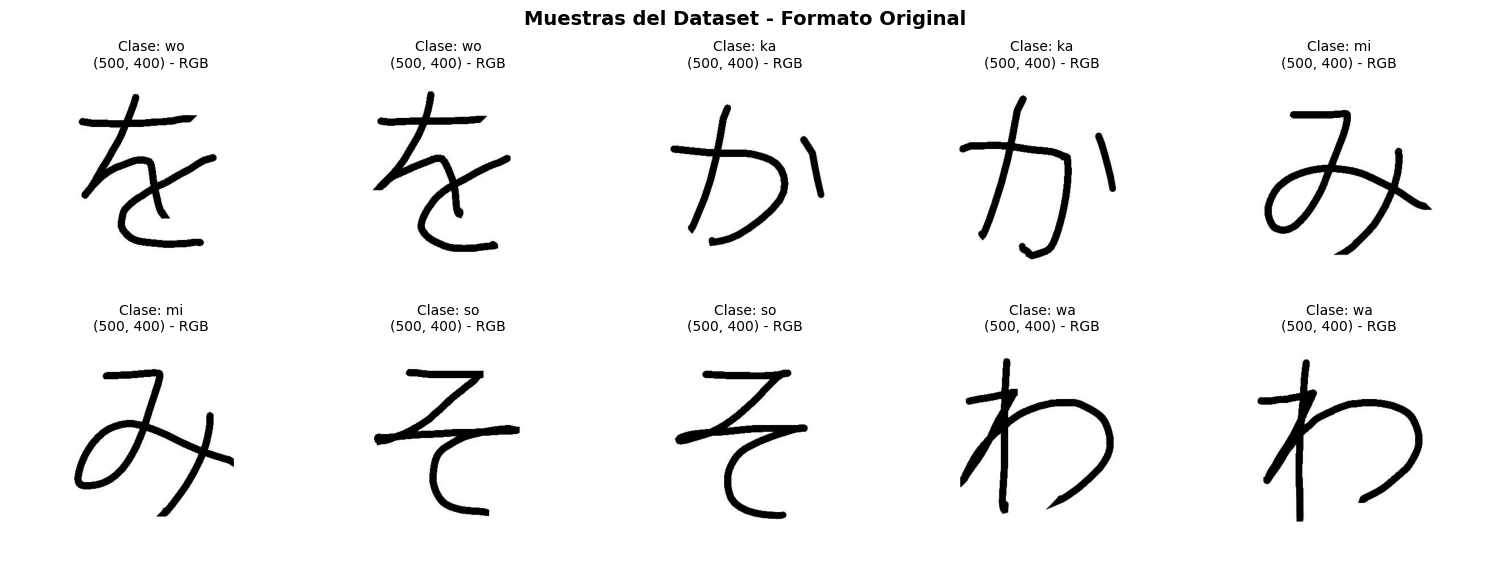

In [8]:
# Analizar propiedades de varias imágenes
import matplotlib.pyplot as plt

def analyze_image_properties(base_path, num_samples=10):
    """
    Analiza las propiedades de imágenes del dataset
    """
    print("Análisis de propiedades de imágenes:")
    print("\n")

    # Tomar muestras de diferentes clases
    train_path = os.path.join(base_path, 'train')
    classes = os.listdir(train_path)[:5]  # Primeras 5 clases

    sizes = []
    modes = []
    sample_images = []

    for cls in classes:
        class_path = os.path.join(train_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')][:2]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            sizes.append(img.size)
            modes.append(img.mode)
            sample_images.append((img, cls))

    # Estadísticas
    unique_sizes = set(sizes)
    unique_modes = set(modes)

    print(f"Dimensiones encontradas: {unique_sizes}")
    print(f"Modos de color: {unique_modes}")
    print(f"Total analizado: {len(sizes)} imágenes")

    return sample_images

# Analizar imágenes
samples = analyze_image_properties(base_output_path)

# Visualizar muestras
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, (img, cls) in enumerate(samples):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'Clase: {cls}\n{img.size} - {img.mode}', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Muestras del Dataset - Formato Original', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Pre-procesamiento

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

print("Configuración entorno")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")


Configuración entorno
TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:

# CONFIGURACIÓN DE HIPERPARÁMETROS
print("\nDefinición de hiperparámetros")
print("\n")

# Dimensiones de la imagen
IMG_HEIGHT = 64  # Altura a la que redimensionaremos
IMG_WIDTH = 64   # Ancho a la que redimensionaremos
IMG_CHANNELS = 1 # 1 = escala de grises

# Parámetros de entrenamiento
BATCH_SIZE = 32      # Cuántas imágenes procesa a la vez
EPOCHS = 20          # Cuántas veces pasa por todo el dataset
LEARNING_RATE = 0.001 # Qué tan grande son los pasos del optimizador

# Clases
NUM_CLASSES = 46     # Los 46 caracteres hiragana

print(f" Tamaño de imagen: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f" Batch size: {BATCH_SIZE}")
print(f" Epochs: {EPOCHS}")
print(f" Learning rate: {LEARNING_RATE}")
print(f" Número de clases: {NUM_CLASSES}")


Definición de hiperparámetros


 Tamaño de imagen: 64x64x1
 Batch size: 32
 Epochs: 20
 Learning rate: 0.001
 Número de clases: 46


In [11]:

# PREPARACIÓN DE LOS DATOS
print("\nPreparación de generadores de datos")

# ImageDataGenerator: clase que carga y preprocesa imágenes automáticamente
# Explicación del preprocesamiento:
# 1. rescale=1./255: Divide cada píxel por 255 (convierte de 0-255 a 0-1)

# Generador para ENTRENAMIENTO
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización: convierte valores de 0-255 a 0-1
)

# Generador para VALIDACIÓN
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Generador para TEST
test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("Generadores creados (solo con normalización)")


Preparación de generadores de datos
Generadores creados (solo con normalización)


In [12]:
# carga de imagenes desde las carpetas


print("\nCargando imágenes desde carpetas")

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_output_path, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Redimensionar a 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Para 46 clases (one-hot encoding)
    color_mode='grayscale',    # Convertir a escala de grises (1 canal)
    shuffle=True,              # Mezclar las imágenes
    seed=42                    # Para reproducibilidad
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_output_path, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,  # No mezclar para evaluación consistente
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_output_path, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,  # No mezclar para evaluación consistente
    seed=42
)

print(f"\n Train: {train_generator.samples} imágenes, {len(train_generator)} batches")
print(f" Validation: {val_generator.samples} imágenes, {len(val_generator)} batches")
print(f" Test: {test_generator.samples} imágenes, {len(test_generator)} batches")

# Guardar el mapeo de clases para usar después
class_indices = train_generator.class_indices
print(f"\n Clases detectadas: {len(class_indices)}")
print(f"Primeras 5 clases: {list(class_indices.keys())[:5]}")


Cargando imágenes desde carpetas
Found 3220 images belonging to 46 classes.
Found 690 images belonging to 46 classes.
Found 690 images belonging to 46 classes.

 Train: 3220 imágenes, 101 batches
 Validation: 690 imágenes, 22 batches
 Test: 690 imágenes, 22 batches

 Clases detectadas: 46
Primeras 5 clases: ['aa', 'chi', 'ee', 'fu', 'ha']



Visualización de muestras preprocesadas


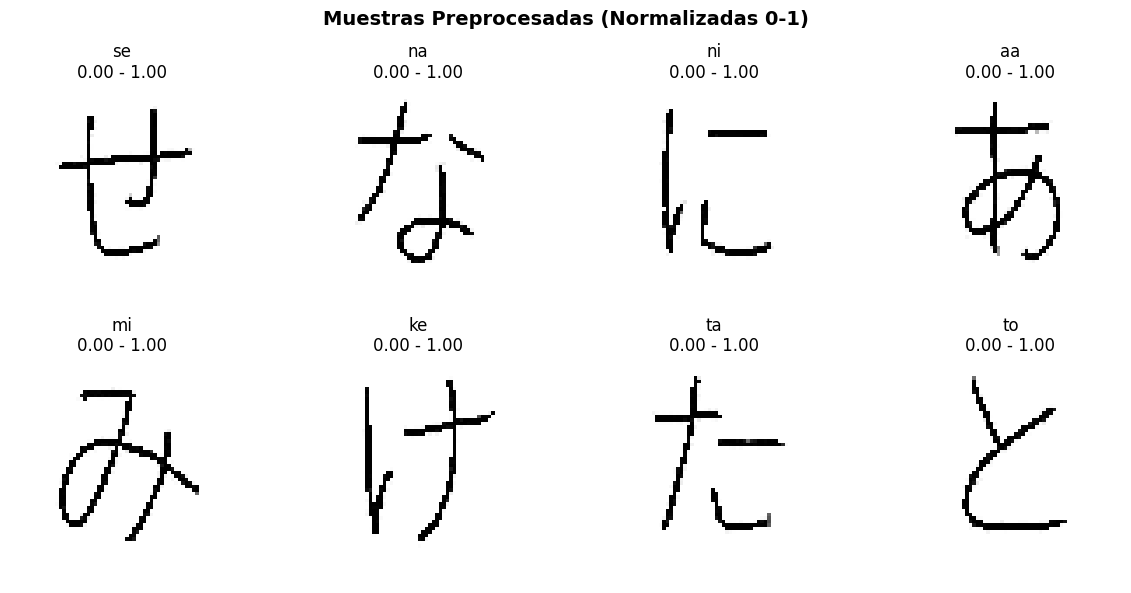


Shape de cada imagen: (64, 64, 1)
Shape de las etiquetas: (46,)
Rango de valores: [0.000, 1.000]


In [15]:

# VISUALIZAR UN BATCH PARA VERIFICAR
print("\nVisualización de muestras preprocesadas")


# Obtener un batch de imágenes
sample_batch, sample_labels = next(train_generator)

# Visualizar algunas imágenes
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Crear diccionario invertido para obtener nombres de clases
idx_to_class = {v: k for k, v in class_indices.items()}

for i in range(8):
    # sample_batch[i] tiene shape (64, 64, 1)
    img = sample_batch[i].squeeze()

    # sample_labels[i] es one-hot, obtener el índice de la clase
    class_idx = np.argmax(sample_labels[i])
    class_name = idx_to_class[class_idx]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{class_name}\n{img.min():.2f} - {img.max():.2f}')
    axes[i].axis('off')

plt.suptitle('Muestras Preprocesadas (Normalizadas 0-1)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nShape de cada imagen: {sample_batch[0].shape}")
print(f"Shape de las etiquetas: {sample_labels[0].shape}")
print(f"Rango de valores: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

# Creación de arquitectura de la CNN

In [16]:
model = models.Sequential(name='Hiragana_CNN')

# Conv2D: Detecta características básicas (bordes, líneas)
# - 32 filtros: aprenderá 32 patrones diferentes
# - (3,3): tamaño del filtro (ventana que recorre la imagen)
# - activation='relu': función de activación (introduce no-linealidad)
# - input_shape: forma de entrada (64x64x1)

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                        name='conv1'))
print("Capa Conv2D_1: 32 filtros (3x3) - Detecta bordes y líneas básicas")

# MaxPooling2D: Reduce el tamaño de la imagen a la mitad
# - (2,2): toma el valor máximo de cada región 2x2
# - Reduce dimensiones y hace el modelo más robusto
model.add(layers.MaxPooling2D((2, 2), name='pool1'))
print("Capa MaxPool_1: (2x2) - Reduce de 64x64 a 32x32")

# Segunda capa convolucional + Pooling
# Más filtros (64) para detectar características más complejas
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2'))
print("Capa Conv2D_2: 64 filtros (3x3) - Detecta formas más complejas")

model.add(layers.MaxPooling2D((2, 2), name='pool2'))
print("Capa MaxPool_2: (2x2) - Reduce de 32x32 a 16x16")

# Tercera capa convolucional + Pooling
# Aún más filtros (128) para patrones muy específicos
model.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv3'))
print("Capa Conv2D_3: 128 filtros (3x3) - Detecta patrones específicos de caracteres")

model.add(layers.MaxPooling2D((2, 2), name='pool3'))
print("Capa MaxPool_3: (2x2) - Reduce de 16x16 a 8x8")

# Aplanar y capas densas (Fully Connected)
# Flatten: Convierte la matriz 3D en un vector 1D
# Esto es necesario para conectar con las capas densas
model.add(layers.Flatten(name='flatten'))
print("Capa Flatten: Convierte matriz 3D en vector 1D")

# Dense: Capa totalmente conectada
# - 256 neuronas: aprende combinaciones de las características detectadas
# - Dropout: Apaga aleatoriamente 50% de neuronas durante entrenamiento
#   Esto previene overfitting (memorización)
model.add(layers.Dense(256, activation='relu', name='dense1'))
print("Capa Dense_1: 256 neuronas - Aprende combinaciones de características")

model.add(layers.Dropout(0.5, name='dropout1'))
print("Capa Dropout: 50% - Previene overfitting")

# CAPA DE SALIDA
# Dense final: Una neurona por cada clase (46)
# - activation='softmax': Convierte salidas en probabilidades que suman 1
# - Cada neurona representa la probabilidad de una clase
model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='output'))
print("Capa Output: 46 neuronas (softmax) - Una por cada carácter hiragana")



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Capa Conv2D_1: 32 filtros (3x3) - Detecta bordes y líneas básicas
Capa MaxPool_1: (2x2) - Reduce de 64x64 a 32x32
Capa Conv2D_2: 64 filtros (3x3) - Detecta formas más complejas
Capa MaxPool_2: (2x2) - Reduce de 32x32 a 16x16
Capa Conv2D_3: 128 filtros (3x3) - Detecta patrones específicos de caracteres
Capa MaxPool_3: (2x2) - Reduce de 16x16 a 8x8
Capa Flatten: Convierte matriz 3D en vector 1D
Capa Dense_1: 256 neuronas - Aprende combinaciones de características
Capa Dropout: 50% - Previene overfitting
Capa Output: 46 neuronas (softmax) - Una por cada carácter hiragana


In [19]:
model.summary()

total_params = model.count_params()

print(f"\nTotal de parametros {total_params}")

Model: "Hiragana_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 46)             │        11,822 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,398 (4.90 MB)

 Trainable params: 1,284,398 (4.90 MB)

 Non-trainable params: 0 (0.00 B)


Total de parametros 1284398


In [21]:
#compilar modelo
print("\nCompilación del modelo")

# Compilar: Configurar cómo el modelo aprenderá
model.compile(
    # Optimizador: Algoritmo que ajusta los pesos
    # Adam: Adaptativo, funciona bien en la mayoría de casos
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),

    # Función de pérdida: Qué tan "equivocado" está el modelo
    # categorical_crossentropy: Para clasificación multiclase
    loss='categorical_crossentropy',

    # Métricas: Qué mostrar durante el entrenamiento
    # accuracy: % de predicciones correctas
    metrics=['accuracy']
)

print("Optimizador: Adam")
print(f"Learning rate: {LEARNING_RATE}")
print("Función de pérdida: Categorical Crossentropy")
print("Métrica: Accuracy")
print("\nModelo compilado y listo para entrenar")


Compilación del modelo
Optimizador: Adam
Learning rate: 0.001
Función de pérdida: Categorical Crossentropy
Métrica: Accuracy

Modelo compilado y listo para entrenar
